In [1]:
import os
import time
import numpy as np
import pandas as pd
import pickle as pkl
import nibabel as nib
from os.path import join as pjoin
from matplotlib import pyplot as plt
from magicbox.io.io import CiftiReader
from magicbox.algorithm.plot import plot_bar
from cxy_visual_dev.lib.predefine import proj_dir,\
    s1200_1096_myelin, s1200_1096_thickness, dataset_name2info

anal_dir = pjoin(proj_dir, 'analysis')
work_dir = pjoin(anal_dir, 'plot/tmp')
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

# 画出HCPD, HCPYA, HCPA重叠年龄平均map的两两之间的散点图，观察能否找到两个数据集之间系统性误差的关系。

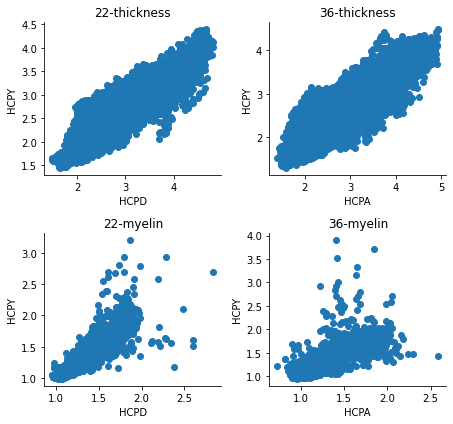

In [5]:
figsize = (6.4, 6)
meas_names = ('thickness', 'myelin')
meas_files = pjoin(proj_dir, 'analysis/structure/{0}_{1}_age-map-mean.dscalar.nii')
dataset_name_pairs = [('HCPD', 'HCPY'), ('HCPA', 'HCPY')]
trg_ages = ['22', '36']
_, axes = plt.subplots(len(meas_names), len(dataset_name_pairs), figsize=figsize)
for i, meas_name in enumerate(meas_names):
    for j, name_pair in enumerate(dataset_name_pairs):
        ax = axes[i, j]
        trg_age = trg_ages[j]
        meas_file1 = meas_files.format(name_pair[0], meas_name)
        meas_file2 = meas_files.format(name_pair[1], meas_name)
        reader1 = CiftiReader(meas_file1)
        reader2 = CiftiReader(meas_file2)
        idx1 = reader1.map_names().index(trg_age)
        idx2 = reader2.map_names().index(trg_age)
        map1 = reader1.get_data()[idx1]
        map2 = reader2.get_data()[idx2]
        ax.scatter(map1, map2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel(f'{name_pair[0]}')
        ax.set_ylabel(f'{name_pair[1]}')
        ax.set_title(f'{trg_age}-{meas_name}')
plt.tight_layout()
plt.savefig(pjoin(work_dir, 'scatter_between_dataset_overlapping-age.jpg'))


# 用置换检验看重叠年龄平均map之间的欧氏距离是否异常，以及zscore能否通过这个考验。

In [2]:
meas_names = ('thickness', 'myelin')
dataset_name_pairs = [('HCPD', 'HCPY'), ('HCPA', 'HCPY')]
trg_ages = [22, 36]

## 置换检验

In [9]:
N = 10000  # 置换检验的迭代次数
# meas2dataset2file = {
#     'thickness': {
#         'HCPD': pjoin(proj_dir, 'data/HCP/HCPD_thickness.dscalar.nii'),
#         'HCPY': s1200_1096_thickness,
#         'HCPA': pjoin(proj_dir, 'data/HCP/HCPA_thickness.dscalar.nii')
#     },
#     'myelin': {
#         'HCPD': pjoin(proj_dir, 'data/HCP/HCPD_myelin.dscalar.nii'),
#         'HCPY': s1200_1096_myelin,
#         'HCPA': pjoin(proj_dir, 'data/HCP/HCPA_myelin.dscalar.nii')
#     }
# }
meas2dataset2file = {
    'thickness': {
        'HCPD': pjoin(proj_dir, 'data/HCP/HCPD_thickness_zscore.dscalar.nii'),
        'HCPY': pjoin(proj_dir, 'data/HCP/HCPY_thickness_zscore.dscalar.nii'),
        'HCPA': pjoin(proj_dir, 'data/HCP/HCPA_thickness_zscore.dscalar.nii')
    },
    'myelin': {
        'HCPD': pjoin(proj_dir, 'data/HCP/HCPD_myelin_zscore.dscalar.nii'),
        'HCPY': pjoin(proj_dir, 'data/HCP/HCPY_myelin_zscore.dscalar.nii'),
        'HCPA': pjoin(proj_dir, 'data/HCP/HCPA_myelin_zscore.dscalar.nii')
    }
}
out_file = pjoin(work_dir, 'permute_zscore.pkl')

out_data = {}
for meas_name in meas_names:
    out_data[meas_name] = {}
    for j, name_pair in enumerate(dataset_name_pairs):
        time1 = time.time()
        trg_age = trg_ages[j]
        meas_file1 = meas2dataset2file[meas_name][name_pair[0]]
        meas_file2 = meas2dataset2file[meas_name][name_pair[1]]
        info_file1 = dataset_name2info[name_pair[0]]
        info_file2 = dataset_name2info[name_pair[1]]
        df1 = pd.read_csv(info_file1)
        df2 = pd.read_csv(info_file2)
        maps1 = nib.load(meas_file1).get_fdata()[df1['age in years'] == trg_age]
        maps2 = nib.load(meas_file2).get_fdata()[df2['age in years'] == trg_age]

        n_map1 = maps1.shape[0]
        n_map2 = maps2.shape[0]
        idx_vec = np.r_[np.ones(n_map1, bool), np.zeros(n_map2, bool)]
        maps = np.r_[maps1, maps2]
        del maps1, maps2
        diffs = np.zeros(N + 1)
        for k in range(N + 1):
            map1 = np.mean(maps[idx_vec], 0)
            map2 = np.mean(maps[~idx_vec], 0)
            diffs[k] = np.linalg.norm(map1 - map2, ord=2)
            np.random.shuffle(idx_vec)
        out_data[meas_name][name_pair] = diffs
        print(f'Finish {meas_name}-{name_pair}, cost: {time.time() - time1} seconds.')

pkl.dump(out_data, open(out_file, 'wb'))

Finish thickness-('HCPD', 'HCPY'), cost: 467.1382460594177 seconds.
Finish thickness-('HCPA', 'HCPY'), cost: 80.02671980857849 seconds.
Finish myelin-('HCPD', 'HCPY'), cost: 479.2685351371765 seconds.
Finish myelin-('HCPA', 'HCPY'), cost: 66.7187340259552 seconds.


## 画图

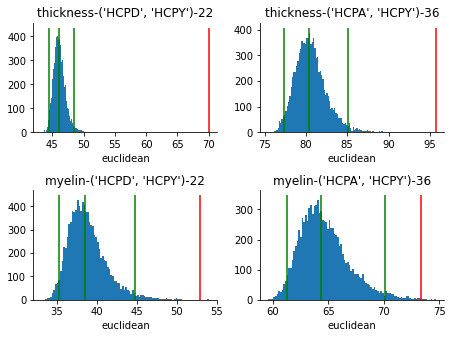

In [10]:
figsize = (6.4, 4.8)
data_file = pjoin(work_dir, 'permute_zscore.pkl')
data = pkl.load(open(data_file, 'rb'))
_, axes = plt.subplots(len(meas_names), len(dataset_name_pairs), figsize=figsize)
for i, meas_name in enumerate(meas_names):
    for j, name_pair in enumerate(dataset_name_pairs):
        ax = axes[i, j]
        diffs = data[meas_name][name_pair]
        vline_x1 = diffs[0]
        vline_x2 = np.percentile(diffs[1:], [2.5, 50, 97.5])
        ax.hist(diffs[1:], bins=100)
        ymin, ymax = ax.get_ylim()
        ax.vlines(vline_x1, ymin, ymax, colors='r')
        ax.vlines(vline_x2, ymin, ymax, colors='g')
        ax.set_xlabel('euclidean')
        ax.set_title(f'{meas_name}-{name_pair}-{trg_ages[j]}')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(pjoin(work_dir, 'permute_zscore.jpg'))

# 直接画

score: 0.5729106197006566


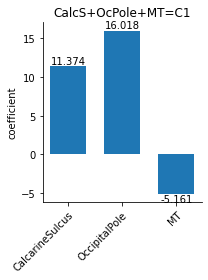

In [3]:
fname = 'CalcS+OcPole+MT=C1'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))
print('score:', df['score_C1'].item())

coef_names = [i for i in df.columns if i.startswith('coef_C1_')]
feat_names = tuple(i.split('_')[-1] for i in coef_names)
plot_bar(y=np.array(df.loc[0, coef_names]), figsize=(3, 4), show_height='.3f',
         xticklabel=feat_names, rotate_xticklabel=True, ylabel='coefficient',
         title=fname, mode=pjoin(work_dir, f'{fname}.jpg'))